In [2]:
import pandas as pd
import optbinning as ob
import sklearn as sl
from optbinning import OptimalBinning, BinningProcess
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
import ydata_profiling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from ydata_profiling import ProfileReport
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [6]:
trainingSample = pd.read_excel('D:/maga_poly/ML/data/external/train.xls', sheet_name = "данные", index_col= False)
testingSample = pd.read_excel('D:/maga_poly/ML/data/external/test.xls', sheet_name = "данные", index_col= False)
target = pd.read_excel('D:/maga_poly/ML/data/external/submission.xls', sheet_name = "данные", index_col= False)
print(trainingSample.columns)


Index(['AGREEMENT_RK', 'TARGET', 'AGE', 'SOCSTATUS_WORK_FL',
       'SOCSTATUS_PENS_FL', 'GENDER', 'CHILD_TOTAL', 'DEPENDANTS', 'EDUCATION',
       'MARITAL_STATUS', 'GEN_INDUSTRY', 'GEN_TITLE', 'ORG_TP_STATE',
       'ORG_TP_FCAPITAL', 'JOB_DIR', 'FAMILY_INCOME', 'PERSONAL_INCOME',
       'REG_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE',
       'POSTAL_ADDRESS_PROVINCE', 'TP_PROVINCE', 'REGION_NM', 'REG_FACT_FL',
       'FACT_POST_FL', 'REG_POST_FL', 'REG_FACT_POST_FL',
       'REG_FACT_POST_TP_FL', 'FL_PRESENCE_FL', 'OWN_AUTO', 'AUTO_RUS_FL',
       'HS_PRESENCE_FL', 'COT_PRESENCE_FL', 'GAR_PRESENCE_FL',
       'LAND_PRESENCE_FL', 'CREDIT', 'TERM', 'FST_PAYMENT', 'DL_DOCUMENT_FL',
       'GPF_DOCUMENT_FL', 'FACT_LIVING_TERM', 'WORK_TIME', 'FACT_PHONE_FL',
       'REG_PHONE_FL', 'GEN_PHONE_FL', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED',
       'LOAN_NUM_PAYM', 'LOAN_DLQ_NUM', 'LOAN_MAX_DLQ', 'LOAN_AVG_DLQ_AMT',
       'LOAN_MAX_DLQ_AMT', 'PREVIOUS_CARD_NUM_UTILIZED'],
      dtype='object')


<h2>Кодирование</h2>

In [7]:
col_list = trainingSample.columns.tolist()
col_list.remove('TARGET')
woe_encoder = ce.WOEEncoder(cols = col_list)
# Предобработка данных
X_train = trainingSample.drop(columns=['TARGET'])
y_train = trainingSample['TARGET']

# Инициализация и обучение WOEEncoder
woe_encoder = ce.WOEEncoder(cols=col_list)
X_train_encoded = woe_encoder.fit_transform(X_train, y_train)

In [8]:
X_test = testingSample
print(np.sort(X_train["POSTAL_ADDRESS_PROVINCE"].unique()))
print(np.sort(X_test["POSTAL_ADDRESS_PROVINCE"].unique()))

['Агинский Бурятский АО' 'Адыгея' 'Алтайский край' 'Амурская область'
 'Архангельская область' 'Астраханская область' 'Башкирия'
 'Белгородская область' 'Брянская область' 'Бурятия'
 'Владимирская область' 'Волгоградская область' 'Вологодская область'
 'Воронежская область' 'Горный Алтай' 'Еврейская АО' 'Ивановская область'
 'Иркутская область' 'Кабардино-Балкария' 'Калининградская область'
 'Калмыкия' 'Калужская область' 'Камчатская область' 'Карачаево-Черкесия'
 'Карелия' 'Кемеровская область' 'Кировская область' 'Коми'
 'Костромская область' 'Краснодарский край' 'Красноярский край'
 'Курганская область' 'Курская область' 'Ленинградская область'
 'Липецкая область' 'Магаданская область' 'Марийская республика'
 'Мордовская республика' 'Москва' 'Московская область'
 'Мурманская область' 'Нижегородская область' 'Новгородская область'
 'Новосибирская область' 'Омская область' 'Оренбургская область'
 'Орловская область' 'Пензенская область' 'Пермская область'
 'Приморский край' 'Псковская

In [9]:
model = LogisticRegression(
    penalty='l1', # Штраф - L1

        class_weight='balanced', # 
        solver='liblinear', # алгоритм оптимизации 
        max_iter=1000, # максимальное количество итераций оптимизации
        random_state=42 # контроль случайности
)
model.fit(X_train_encoded, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [10]:

# Преобразование тестовых данных
X_test = testingSample[col_list]
X_test_encoded = woe_encoder.transform(X_test)

# Предсказание вероятностей
y_pred = model.predict_proba(X_test_encoded)[:, 1]

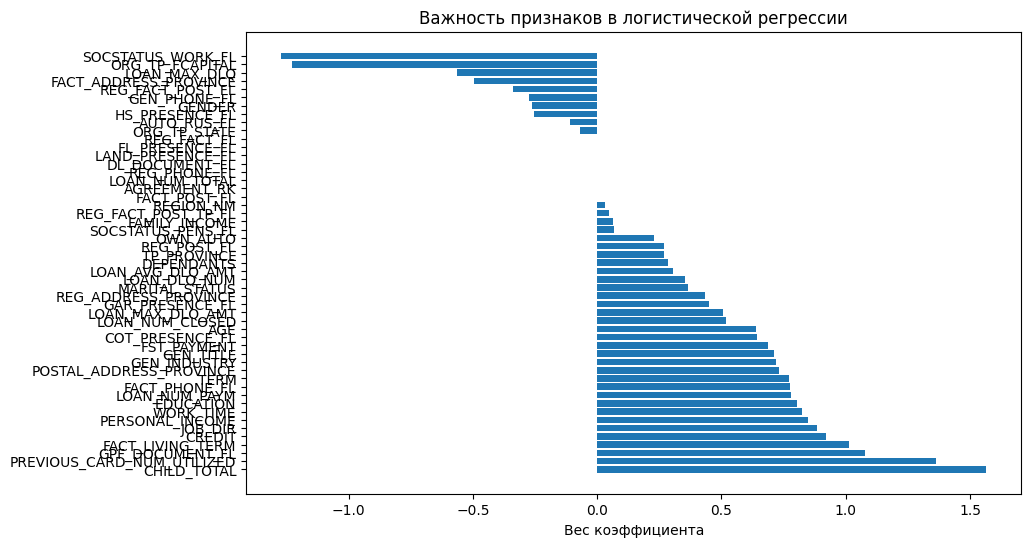

In [11]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.title('Важность признаков в логистической регрессии')
plt.xlabel('Вес коэффициента')
plt.show()


Оценка качества модели:
ROC-AUC = 0.6452


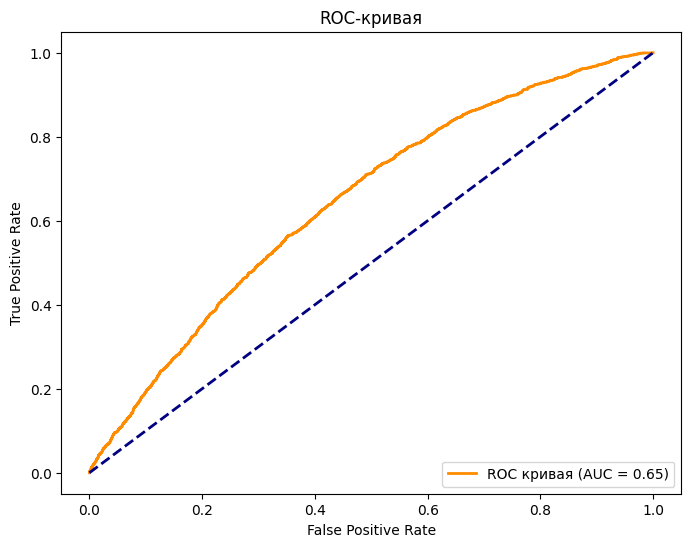

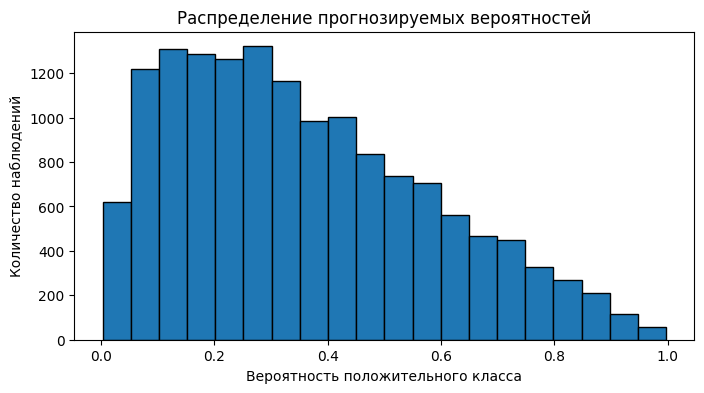

In [12]:
if not target.index.equals(testingSample.index):
        print("Внимание: Индексы тестовых данных и меток не совпадают!")
        print("Рекомендуется выполнить сброс индексов:")
        target = target.reset_index(drop=True)
        testingSample = testingSample.reset_index(drop=True)

    # Расчет метрик
roc_auc = metrics.roc_auc_score(target, y_pred)
print(f"\nОценка качества модели:")
print(f"ROC-AUC = {roc_auc:.4f}")

    # Построение ROC-кривой
fpr, tpr, _ = metrics.roc_curve(target, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

    # Дополнительная проверка распределения
plt.figure(figsize=(8, 4))
plt.hist(y_pred, bins=20, edgecolor='k')
plt.title('Распределение прогнозируемых вероятностей')
plt.xlabel('Вероятность положительного класса')
plt.ylabel('Количество наблюдений')
plt.show()

In [14]:
trainingSample = pd.read_excel('D:/maga_poly/ML/data/external/train.xls', sheet_name="данные", index_col=False)
testingSample = pd.read_excel('D:/maga_poly/ML/data/external/test.xls', sheet_name="данные", index_col=False)
target = pd.read_excel('D:/maga_poly/ML/data/external/submission.xls', sheet_name="данные", index_col=False)

X_train = trainingSample.drop(columns=['TARGET'])
y_train = trainingSample['TARGET']
X_test = testingSample

numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

X_train = X_train[numeric_features].copy()
X_test = X_test[numeric_features].copy()

binning_process = BinningProcess(
    variable_names=numeric_features,
    categorical_variables=[],
    # Важно: отключаем автоматический отсев переменных
    max_n_prebins=20,
    min_prebin_size=0.05,
    min_n_bins=2
)
X_train_binned = binning_process.fit_transform(X_train[numeric_features], y_train)
X_test_binned = binning_process.transform(X_test[numeric_features])
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


In [15]:

model1 = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.035,
    colsample_bytree=0.7,
    gamma=0.02,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    tree_method='auto'
)
model1.fit(
    X_train_binned, y_train,
    eval_set=[(X_test_binned, target)],
    # early_stopping_rounds=100,
    verbose=False
)
y_pred1 = model1.predict_proba(X_test_binned)[:, 1]

In [20]:
# С заголовками и табуляцией
X_test_binned.to_csv('output.txt', sep=',', index=False, header=True, lineterminator = ';')

In [22]:
print(y_pred1)
model1.predict_proba(X_test_binned.head(1))[:, 1]

[0.04002819 0.01485476 0.04370365 ... 0.1158106  0.00323384 0.30956623]


array([0.04002819], dtype=float32)

In [25]:
import os
import pickle
with open('D:/maga_poly/ML/notebooks/model1.pkl', 'rb') as f:
        model = pickle.load(f)
        print("Ваша модель успешно загружена")

Ваша модель успешно загружена


In [31]:
res = model.predict_proba(X_test_binned.head(1))[:, 1]

print(res)

[0.04002819]


In [23]:

with open('model1.pkl','wb') as f:
    pickle.dump(model1,f)
    pcl1 = pickle.dump(model1,f)


ROC-AUC после бининга = 0.6628


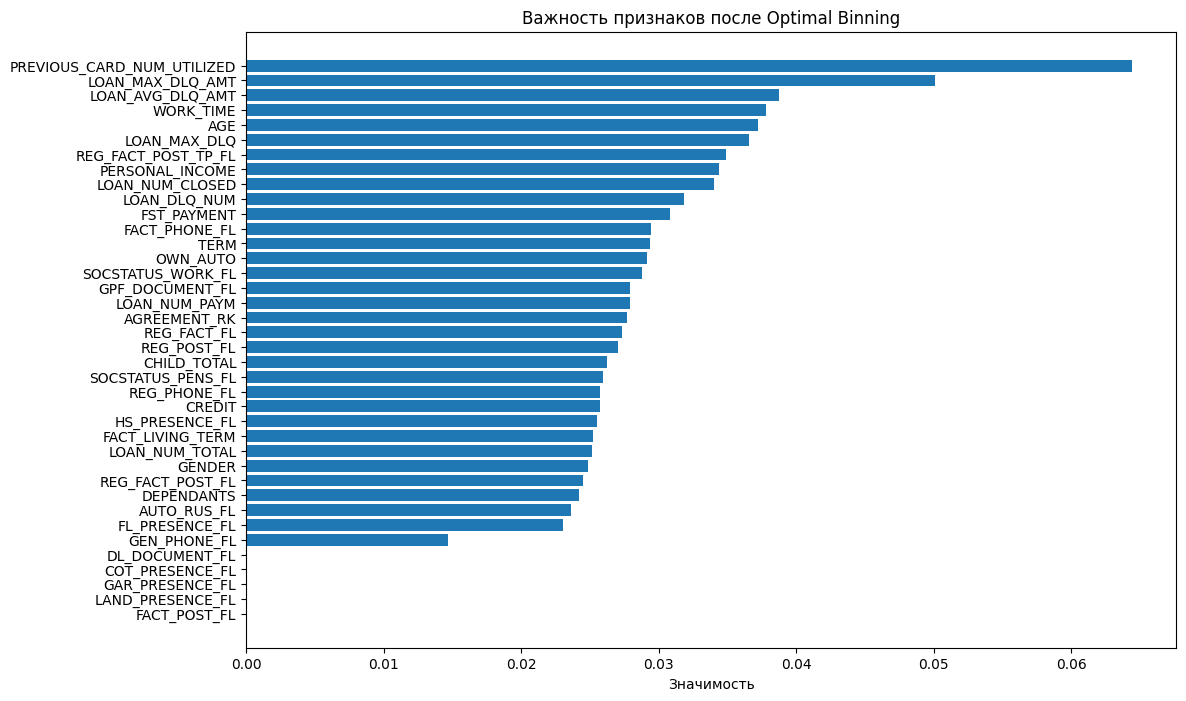

In [16]:
roc_auc = roc_auc_score(target, y_pred1)
print(f"\nROC-AUC после бининга = {roc_auc:.4f}")

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
sorted_idx = model1.feature_importances_.argsort()
plt.barh(X_train_binned.columns[sorted_idx], model1.feature_importances_[sorted_idx])
plt.title('Важность признаков после Optimal Binning')
plt.xlabel('Значимость')
plt.show()
